In [1]:
# General Imports
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread


2024-10-25 09:16:08.742927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 09:16:08.743606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 09:16:08.750497: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 09:16:08.759050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 09:16:08.773024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/brain-tumor-detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/brain-tumor-detector'

---

## Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/brain-tumor-mri-dataset/mri-images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set output directory

In [6]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['glioma', 'meningioma', 'notumor', 'pituitary']


---

## Data distribution

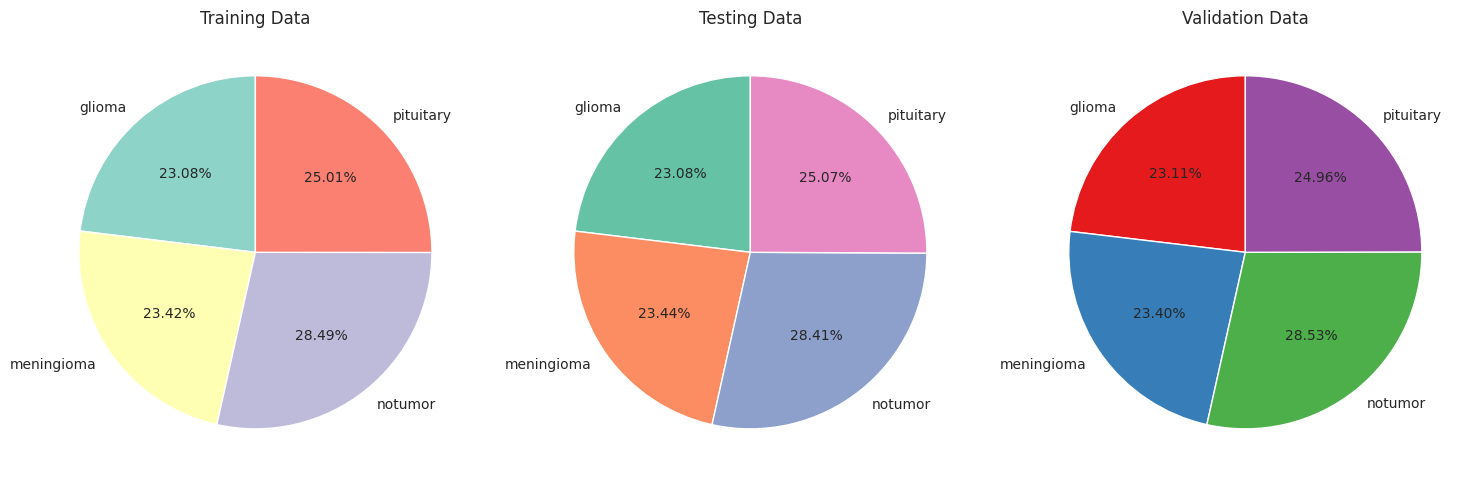

Training Counts: {'glioma': 1134, 'meningioma': 1151, 'notumor': 1400, 'pituitary': 1229}
Testing Counts: {'glioma': 325, 'meningioma': 330, 'notumor': 400, 'pituitary': 353}
Validation Counts: {'glioma': 162, 'meningioma': 164, 'notumor': 200, 'pituitary': 175}


In [8]:
# Define paths for train, test, and validation data
train_path = 'inputs/brain-tumor-mri-dataset/mri-images/train'
test_path = 'inputs/brain-tumor-mri-dataset/mri-images/test'
val_path = 'inputs/brain-tumor-mri-dataset/mri-images/validation'

categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

def count_images(data_path):
    category_count = {}
    for category in categories:
        category_dir = os.path.join(data_path, category)
        num_images = len(os.listdir(category_dir))
        category_count[category] = num_images
    return category_count

# Count images in each dataset (train, test, validation)
train_counts = count_images(train_path)
test_counts = count_images(test_path)
val_counts = count_images(val_path)

# Plot pie chart for training data distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Training Data')

# Plot pie chart for testing data distribution
plt.subplot(1, 3, 2)
plt.pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title('Testing Data')

# Plot pie chart for validation data distribution
plt.subplot(1, 3, 3)
plt.pie(val_counts.values(), labels=val_counts.keys(), autopct='%1.2f%%', startangle=90, colors=sns.color_palette("Set1"))
plt.title('Validation Data')

plt.tight_layout()
plt.show()

print("Training Counts:", train_counts)
print("Testing Counts:", test_counts)
print("Validation Counts:", val_counts)


### Image shape
Compute average images size on train set.

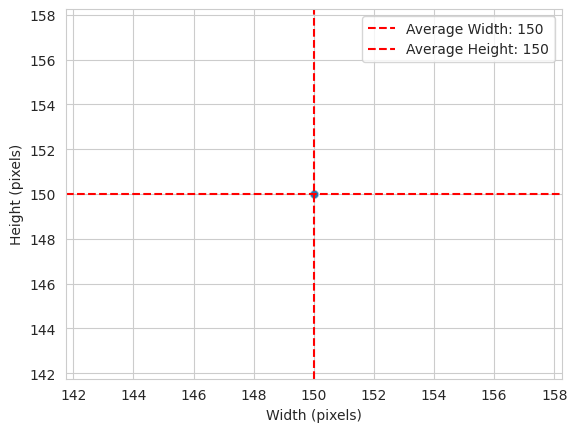

Width average: 150 
Height average: 150
Reshaped Images Shape: (4912, 150, 150, 3)


In [9]:
# Define paths
train_path = 'inputs/brain-tumor-mri-dataset/mri-images/train'
labels = os.listdir(train_path)

dim1 = []  # List to store image heights
dim2 = []  # List to store image widths
reshaped_images = []  # List to store reshaped images


for label in labels:
    for image_filename in os.listdir(os.path.join(train_path, label)):
        img_path = os.path.join(train_path, label, image_filename)
        
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img)  # Decode the image to a tensor
        
        # Check number of channels
        if img.shape[-1] == 1:  # Grayscale image
            img = tf.image.grayscale_to_rgb(img)
        elif img.shape[-1] == 4:  # RGBA image
            img = tf.image.rgb_to_grayscale(img[:, :, :3])  # Ignore alpha channel
        
        # Resize the image to (150, 150, 3)
        img_resized = tf.image.resize(img, [150, 150])
        
        # Append the resized image only if it has the right shape
        if img_resized.shape[-1] == 3:
            reshaped_images.append(img_resized.numpy())  # Convert tensor to numpy array

            # Append dimensions
            dim1.append(img_resized.shape[0])  # height
            dim2.append(img_resized.shape[1])  # width

# Convert reshaped images to a numpy array
reshaped_images = np.array(reshaped_images)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim2_mean, color='r', linestyle='--', label=f"Average Width: {dim2_mean}")
axes.axhline(y=dim1_mean, color='r', linestyle='--', label=f"Average Height: {dim1_mean}")

plt.legend()
plt.show()

print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")
print(f"Reshaped Images Shape: {reshaped_images.shape}")

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(150, 150, 3)

Save the image shape embeddings (will serve for the uploading a MRI brain scan that is not from the dataset)

In [11]:
joblib.dump(value=image_shape,
            filename=os.path.join(file_path, 'image_shape.pkl'))

['outputs/v3/image_shape.pkl']

## Average and variability of images per label
Function to load images in an array (tensor)

In [13]:
def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

Load image shapes and labels in an array

In [14]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(120, 150, 150, 3) (120,)


Plot and save mean and variability of images per label

In [15]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label glioma ====
Image Shape: (150, 150, 3)
==== Label meningioma ====
Image Shape: (150, 150, 3)
==== Label notumor ====
Image Shape: (150, 150, 3)
==== Label pituitary ====
Image Shape: (150, 150, 3)


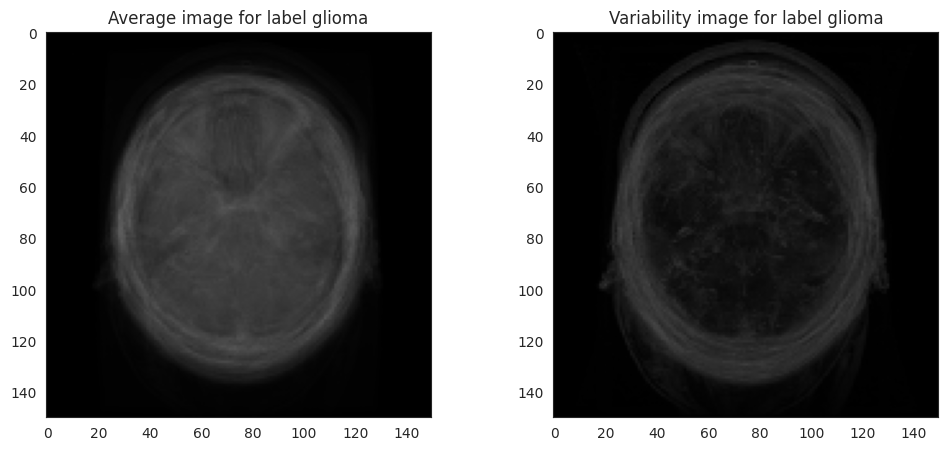

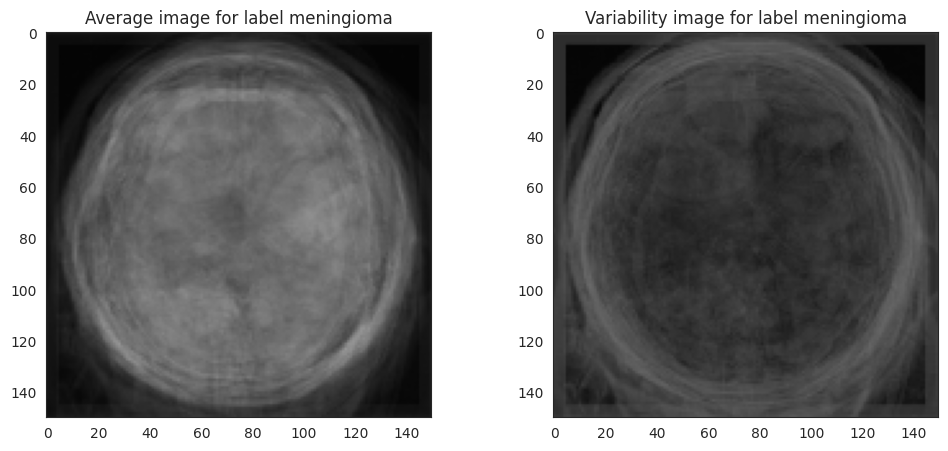

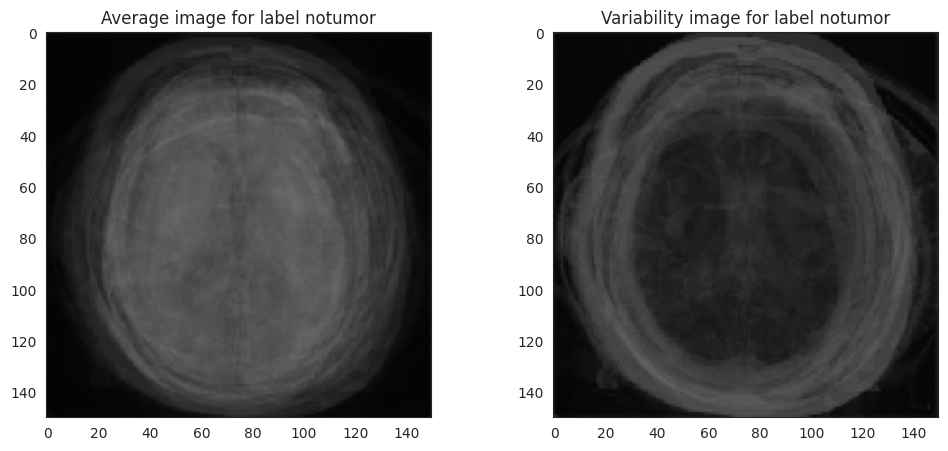

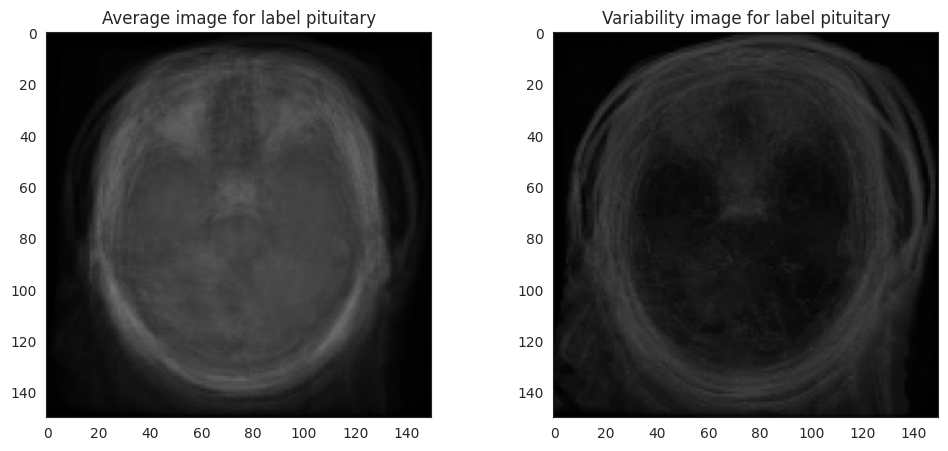

In [16]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

Difference between average normal brain and average a brain with disease (glioma, meningioma or pituitary) images

In [17]:
# Function to extract images based on label
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

# Function to compute difference between average normal and diseased brain images and save them
def diff_bet_avg_normal_vs_diseased(X, y, normal_label, disease_labels, file_path, figsize=(20, 5), save_image=False):
    sns.set_style("white")

    # Create the directory to save images if it doesn't exist
    if save_image and not os.path.exists(file_path):
        os.makedirs(file_path)

    # Check if the normal label exists in the dataset
    if normal_label not in np.unique(y):
        print(f"Normal label {normal_label} not found in labels {np.unique(y)}")
        return

    for disease_label in disease_labels:
        if disease_label not in np.unique(y):
            print(f"Disease label {disease_label} not found in labels {np.unique(y)}")
            continue

        # Calculate the average image for the normal brain (No Tumor)
        normal_images = subset_image_label(X, y, normal_label)
        normal_avg = np.mean(normal_images, axis=0)

        # Calculate the average image for the diseased brain (Glioma, Meningioma, Pituitary)
        disease_images = subset_image_label(X, y, disease_label)
        disease_avg = np.mean(disease_images, axis=0)

        # Calculate the difference between the average normal and diseased brain images
        difference_mean = normal_avg - disease_avg

        # Plot average normal brain, average diseased brain, and the difference
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
        axes[0].imshow(normal_avg, cmap='gray')
        axes[0].set_title(f'Average {normal_label}')
        axes[1].imshow(disease_avg, cmap='gray')
        axes[1].set_title(f'Average {disease_label}')
        axes[2].imshow(difference_mean, cmap='gray')
        axes[2].set_title(f'Difference: {normal_label} & {disease_label}')

        if save_image:
            plt.savefig(f"{file_path}/avg_diff_{normal_label}_vs_{disease_label}.png", bbox_inches='tight', dpi=150)
            print(f"Saved image: avg_diff_{normal_label}_vs_{disease_label}.png")
        else:
            plt.tight_layout()
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08013072366205354..0.34196079036531346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38705882779322565..0.064444441255182].


Saved image: avg_diff_notumor_vs_glioma.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24052288240442674..0.22183006725584467].


Saved image: avg_diff_notumor_vs_meningioma.png


Saved image: avg_diff_notumor_vs_pituitary.png


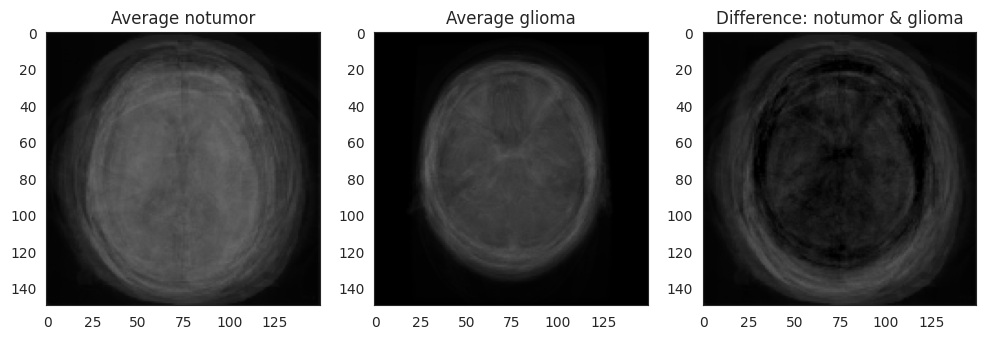

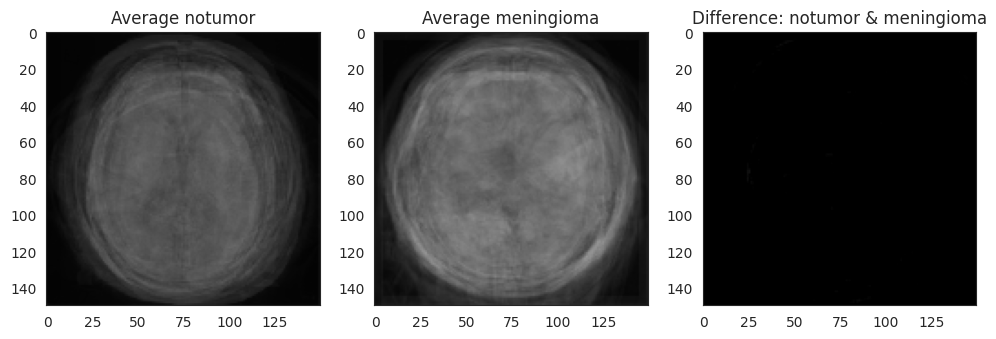

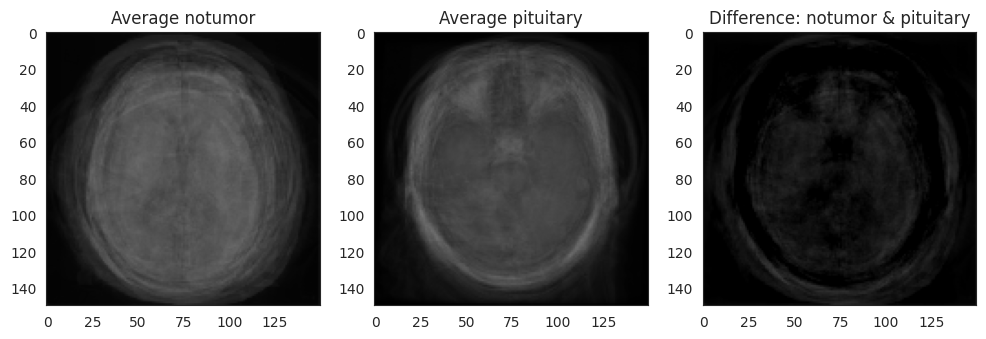

In [18]:

# Labels for normal and diseased brains
normal_label = 'notumor'  # Label for normal brain
disease_labels = ['glioma', 'meningioma', 'pituitary']  # Labels for diseased brain
# Call the function to compare normal brain to each disease label and save the images
diff_bet_avg_normal_vs_diseased(X=X, y=y, normal_label=normal_label, disease_labels=disease_labels, file_path=file_path, figsize=(12, 10), save_image=True)

## Image Montage

In [18]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

glioma


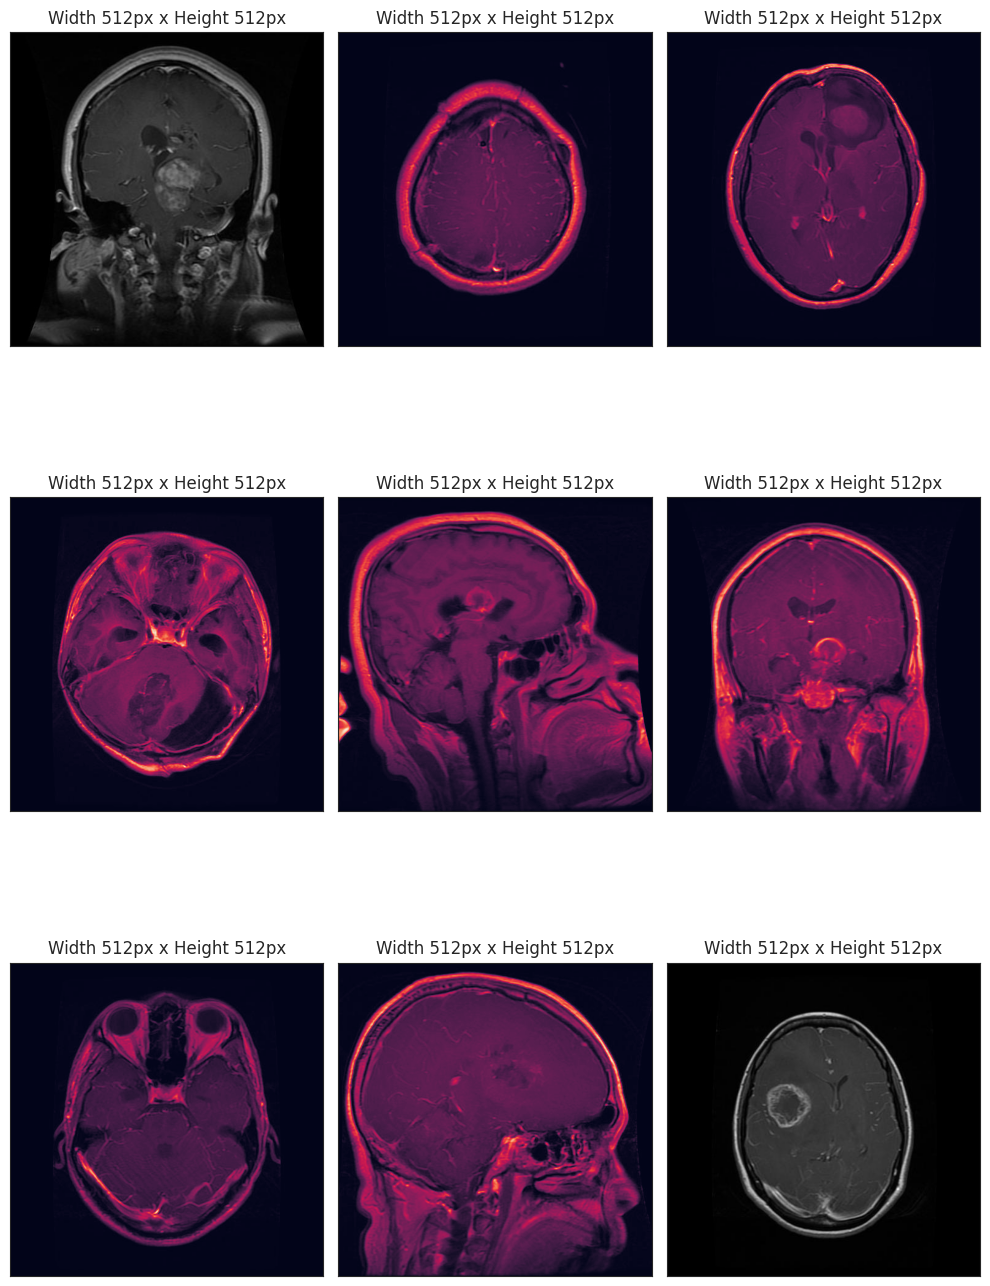



meningioma


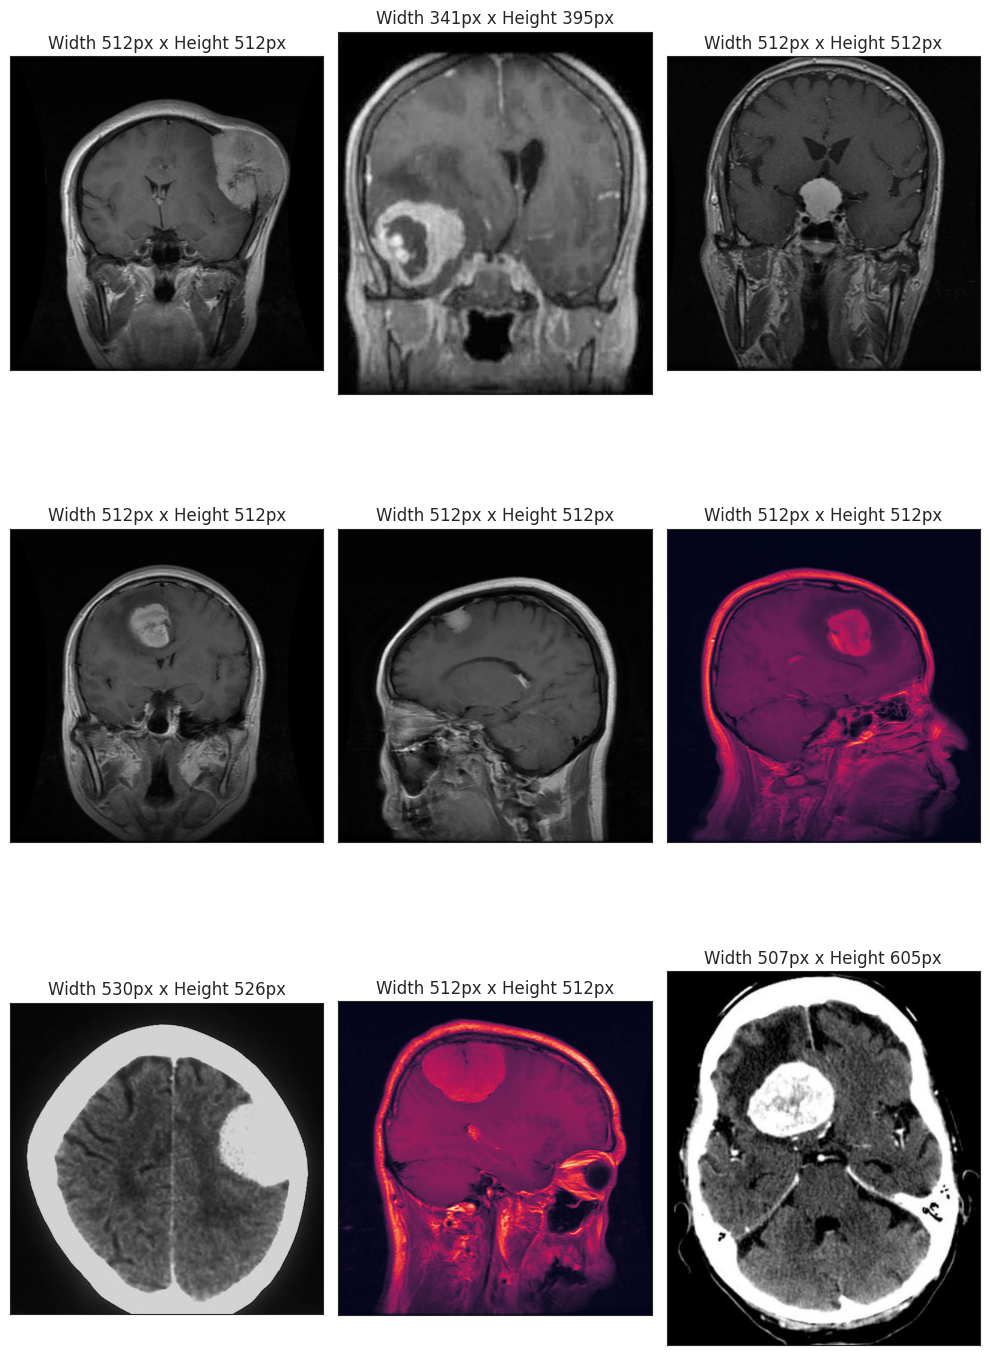



notumor


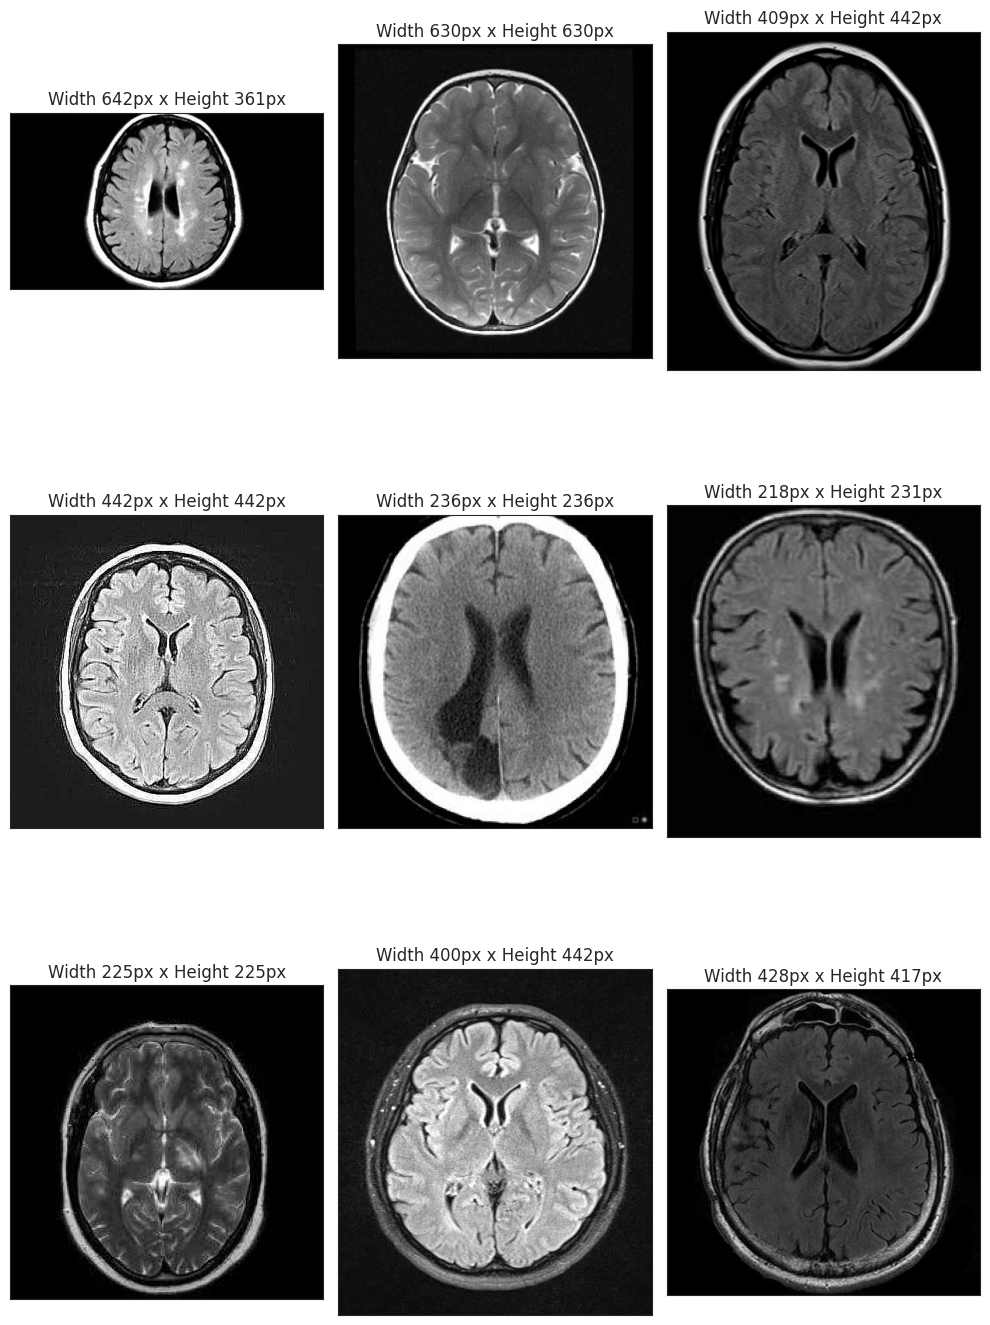



pituitary


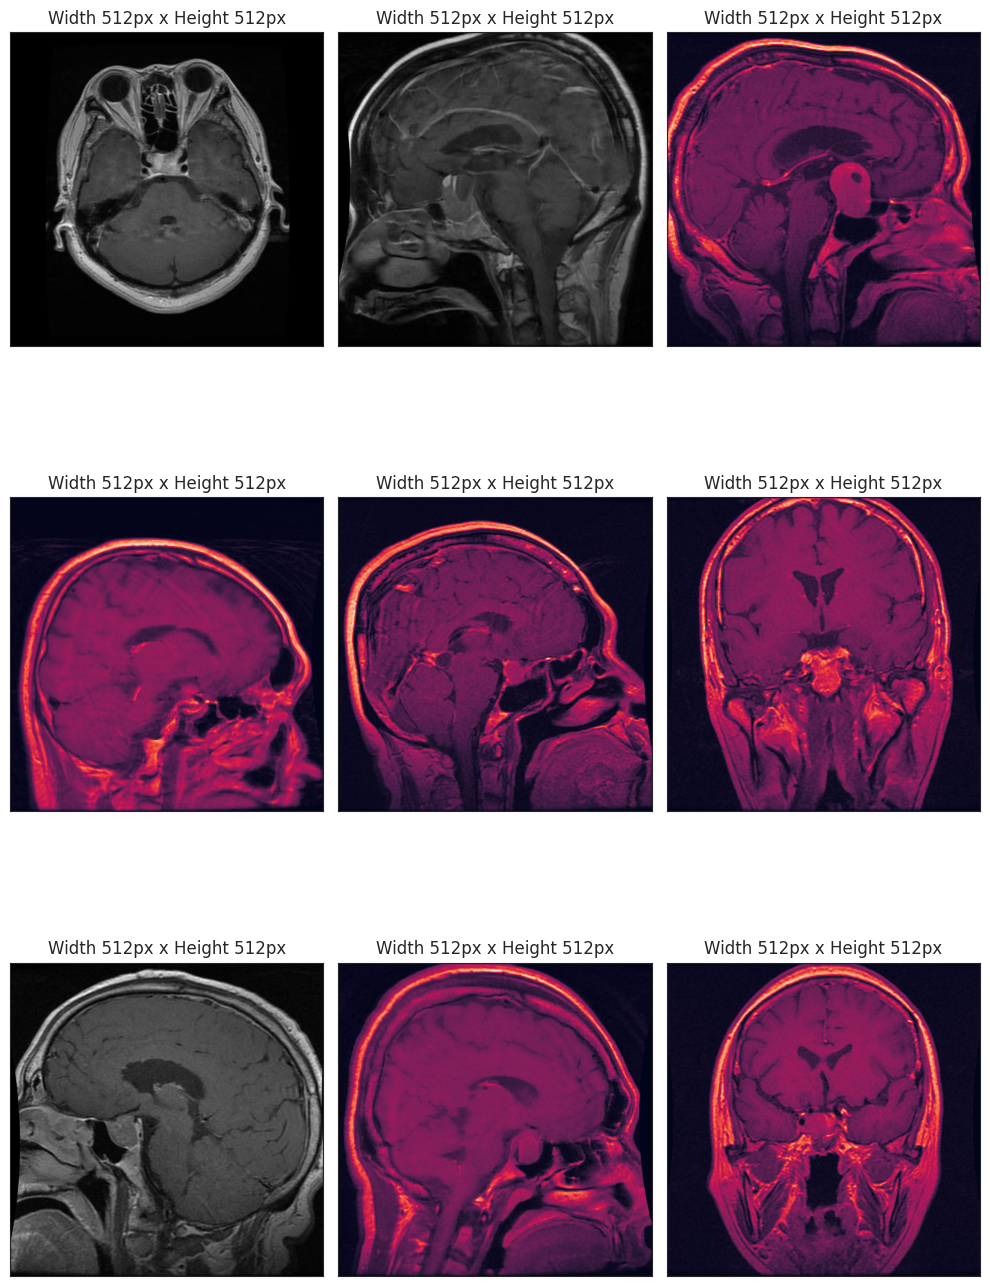

In [19]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

## Conclusion

### Balanced Data Distribution: 
* The dataset contains a relatively balanced number of images across the four categories (Glioma, Meningioma, Pituitary, No Tumor), ensuring fair representation for each class during training.

### Consistent Image Resizing: 
* Images were resized and reshaped to a uniform size of (150, 150, 3), enabling the model to process all images consistently.

### Average Image Size Analysis: 
* The computed average image size and aspect ratio in the training set helped confirm uniformity across the dataset after preprocessing.

### Disease vs. Normal Image Differences: 
* Clear visual distinctions were observed between the average images of normal brains and brains with tumors, supporting the idea that image-based patterns can help differentiate between healthy and diseased states.

### Data Augmentation Strategy: 
* Visualizations demonstrated the variability introduced through data augmentation, enhancing the dataset by generating diverse training samples to improve model robustness.